<a href="https://colab.research.google.com/github/bjih1999/cifar_img_classify_project/blob/master/plz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10
from keras.utils import np_utils
from sklearn.manifold import TSNE
from PIL import Image

In [ ]:
input_shape = (32, 32, 3)
num_classes = 10
epochs = 10
batch_size = 512

In [ ]:
def show_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
 
    loss=history.history['loss']
    val_loss=history.history['val_loss']
 
    epochs_range = range(len(history.history['accuracy']))
    # epochs_range = range(epochs*5)
 
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
def load_image_and_label_regularated():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    train_images = train_images.reshape((50000, 32, 32, 3))
    test_images = test_images.reshape((10000, 32, 32, 3))
    train_images, test_images = train_images / 255.0, test_images / 255.0
    return (train_images, train_labels), (test_images, test_labels)

**get CAM**

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

**save CAM**

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.05):
    heatmap = np.uint8(255 * heatmap)
 
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
 
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
 
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
 
    # Save the superimposed image
    return superimposed_img

**get t-sne**

In [ ]:
def get_tsne(model, layer_name, x_data, y_data, height, width, channel, size=100, batch_size=512):
  feat_extractor = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  features = feat_extractor.predict(x_data[:size], batch_size=batch_size)
  features = features.reshape(size,height*width*channel)
 
  tsne = TSNE().fit_transform(features)
  tx, ty = tsne[:,0], tsne[:,1]
  tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
  ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
 
  y_data = y_data[:size]
  colors = cm.rainbow(np.linspace(0, 1, ))
 
  for i in range(10):
    x_data = np.where(np.where(y_data==1)[1] == i)
    plt.scatter(tx[x_data], ty[x_data], marker='.') 
  plt.show()

**#1 cifar 10 raw data**

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
 
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
model1 = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result1 = model1.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model1.summary()

Epoch 1/10
98/98 [==============================] - 33s 20ms/step - loss: 8.1355 - accuracy: 0.2712 - val_loss: 1.6269 - val_accuracy: 0.4170
Epoch 2/10
98/98 [==============================] - 1s 13ms/step - loss: 1.5005 - accuracy: 0.4648 - val_loss: 1.4062 - val_accuracy: 0.4978
Epoch 3/10
98/98 [==============================] - 1s 13ms/step - loss: 1.3325 - accuracy: 0.5286 - val_loss: 1.3263 - val_accuracy: 0.5287
Epoch 4/10
98/98 [==============================] - 1s 13ms/step - loss: 1.2243 - accuracy: 0.5668 - val_loss: 1.2707 - val_accuracy: 0.5507
Epoch 5/10
98/98 [==============================] - 1s 13ms/step - loss: 1.1308 - accuracy: 0.6032 - val_loss: 1.2526 - val_accuracy: 0.5531
Epoch 6/10
98/98 [==============================] - 1s 13ms/step - loss: 1.0574 - accuracy: 0.6301 - val_loss: 1.3003 - val_accuracy: 0.5439
Epoch 7/10
98/98 [==============================] - 1s 14ms/step - loss: 0.9985 - accuracy: 0.6497 - val_loss: 1.1879 - val_accuracy: 0.5844
Epoch 8/10
9

In [ ]:
test_loss, test_acc = model1.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 1.2014 - accuracy: 0.6036
1.2014018297195435
0.603600025177002


(None, None)

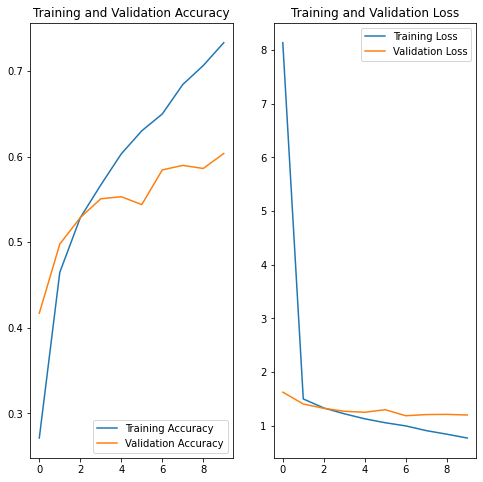

In [ ]:
show_accuracy(result1)

**#2 cifar 10 divided by 255**

In [ ]:
(x_train, y_train), (x_test, y_test) = load_image_and_label_regularated()

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)



In [ ]:
model2 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result2 = model2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model2.summary()

Epoch 1/10
98/98 [==============================] - 2s 18ms/step - loss: 1.7581 - accuracy: 0.3715 - val_loss: 1.5325 - val_accuracy: 0.4457
Epoch 2/10
98/98 [==============================] - 2s 16ms/step - loss: 1.4148 - accuracy: 0.4972 - val_loss: 1.3969 - val_accuracy: 0.5045
Epoch 3/10
98/98 [==============================] - 2s 16ms/step - loss: 1.2779 - accuracy: 0.5501 - val_loss: 1.2106 - val_accuracy: 0.5726
Epoch 4/10
98/98 [==============================] - 2s 16ms/step - loss: 1.1671 - accuracy: 0.5881 - val_loss: 1.1352 - val_accuracy: 0.5953
Epoch 5/10
98/98 [==============================] - 2s 16ms/step - loss: 1.0920 - accuracy: 0.6166 - val_loss: 1.0939 - val_accuracy: 0.6109
Epoch 6/10
98/98 [==============================] - 2s 16ms/step - loss: 1.0297 - accuracy: 0.6397 - val_loss: 1.0525 - val_accuracy: 0.6319
Epoch 7/10
98/98 [==============================] - 2s 16ms/step - loss: 0.9852 - accuracy: 0.6572 - val_loss: 1.0221 - val_accuracy: 0.6442
Epoch 8/10
98

In [ ]:
test_loss, test_acc = model2.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.9523 - accuracy: 0.6674
0.9523327946662903
0.6674000024795532


(None, None)

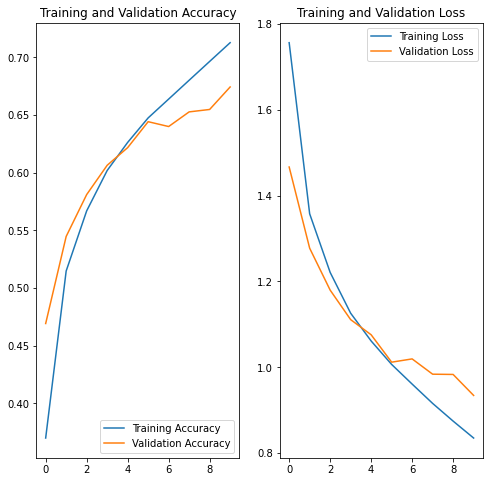

In [ ]:
show_accuracy(result2)

**#3 cifar 10 regularated**


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
 
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
 
mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(x_train.shape)
newX_test = np.ones(x_test.shape)
 
for i in range(3):
    mean[i] = np.mean(x_train[:,:,:,i])
    std[i] = np.std(x_train[:,:,:,i])
 
for i in range(3):
    newX_train[:,:,:,i] = x_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = x_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
        
x_train = newX_train
x_test = newX_test

In [ ]:
model3 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result3 = model3.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model3.summary()

Epoch 1/10
98/98 [==============================] - 2s 19ms/step - loss: 1.6034 - accuracy: 0.4266 - val_loss: 1.3395 - val_accuracy: 0.5227
Epoch 2/10
98/98 [==============================] - 2s 16ms/step - loss: 1.2164 - accuracy: 0.5721 - val_loss: 1.1667 - val_accuracy: 0.5913
Epoch 3/10
98/98 [==============================] - 2s 16ms/step - loss: 1.0672 - accuracy: 0.6257 - val_loss: 1.0617 - val_accuracy: 0.6221
Epoch 4/10
98/98 [==============================] - 2s 16ms/step - loss: 0.9683 - accuracy: 0.6640 - val_loss: 0.9882 - val_accuracy: 0.6504
Epoch 5/10
98/98 [==============================] - 2s 16ms/step - loss: 0.8973 - accuracy: 0.6853 - val_loss: 0.9841 - val_accuracy: 0.6524
Epoch 6/10
98/98 [==============================] - 2s 15ms/step - loss: 0.8321 - accuracy: 0.7116 - val_loss: 0.9248 - val_accuracy: 0.6779
Epoch 7/10
98/98 [==============================] - 2s 16ms/step - loss: 0.7669 - accuracy: 0.7350 - val_loss: 0.9325 - val_accuracy: 0.6786
Epoch 8/10
98

In [ ]:
test_loss, test_acc = model3.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.8649 - accuracy: 0.7060
0.8649224638938904
0.7059999704360962


(None, None)

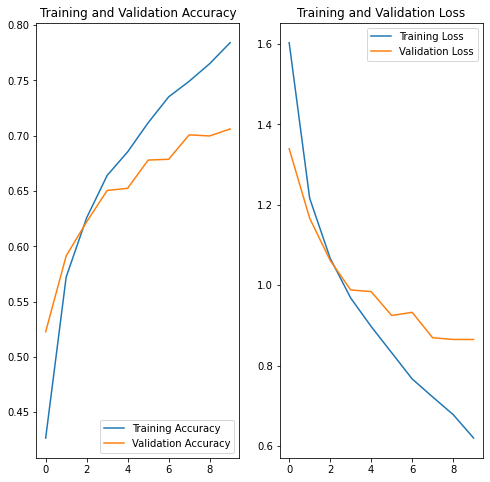

In [ ]:
show_accuracy(result3)

**#4 필터 개수 점점 줄이기**

In [ ]:
model4 = keras.Sequential([
    layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result4 = model4.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model4.summary()

Epoch 1/10
98/98 [==============================] - 3s 26ms/step - loss: 1.6691 - accuracy: 0.4005 - val_loss: 1.3786 - val_accuracy: 0.5033
Epoch 2/10
98/98 [==============================] - 2s 23ms/step - loss: 1.2833 - accuracy: 0.5427 - val_loss: 1.1893 - val_accuracy: 0.5773
Epoch 3/10
98/98 [==============================] - 2s 23ms/step - loss: 1.1472 - accuracy: 0.5943 - val_loss: 1.1097 - val_accuracy: 0.6101
Epoch 4/10
98/98 [==============================] - 2s 23ms/step - loss: 1.0396 - accuracy: 0.6342 - val_loss: 1.0325 - val_accuracy: 0.6337
Epoch 5/10
98/98 [==============================] - 2s 23ms/step - loss: 0.9639 - accuracy: 0.6609 - val_loss: 0.9787 - val_accuracy: 0.6518
Epoch 6/10
98/98 [==============================] - 2s 23ms/step - loss: 0.9099 - accuracy: 0.6818 - val_loss: 0.9440 - val_accuracy: 0.6729
Epoch 7/10
98/98 [==============================] - 2s 23ms/step - loss: 0.8622 - accuracy: 0.6995 - val_loss: 0.9346 - val_accuracy: 0.6730
Epoch 8/10
98

In [ ]:
test_loss, test_acc = model4.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.8826 - accuracy: 0.6953
0.8825554847717285
0.6952999830245972


(None, None)

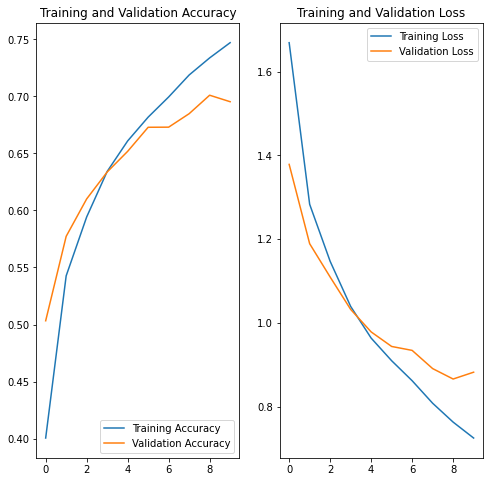

In [ ]:
show_accuracy(result4)

**#5 커널 내림 차순 레이어 증가**

In [ ]:
model5 = keras.Sequential([
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result5 = model5.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model5.summary()

Epoch 1/10
98/98 [==============================] - 8s 67ms/step - loss: 1.7331 - accuracy: 0.3751 - val_loss: 1.4283 - val_accuracy: 0.4802
Epoch 2/10
98/98 [==============================] - 5s 55ms/step - loss: 1.3523 - accuracy: 0.5189 - val_loss: 1.2779 - val_accuracy: 0.5410
Epoch 3/10
98/98 [==============================] - 5s 55ms/step - loss: 1.1612 - accuracy: 0.5893 - val_loss: 1.0883 - val_accuracy: 0.6146
Epoch 4/10
98/98 [==============================] - 5s 55ms/step - loss: 1.0282 - accuracy: 0.6378 - val_loss: 1.0045 - val_accuracy: 0.6439
Epoch 5/10
98/98 [==============================] - 5s 56ms/step - loss: 0.9427 - accuracy: 0.6684 - val_loss: 0.9323 - val_accuracy: 0.6704
Epoch 6/10
98/98 [==============================] - 5s 56ms/step - loss: 0.8726 - accuracy: 0.6929 - val_loss: 0.8806 - val_accuracy: 0.6930
Epoch 7/10
98/98 [==============================] - 5s 55ms/step - loss: 0.8089 - accuracy: 0.7154 - val_loss: 0.9058 - val_accuracy: 0.6881
Epoch 8/10
98

In [ ]:
test_loss, test_acc = model5.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.8163 - accuracy: 0.7195
0.8162610530853271
0.7195000052452087


(None, None)

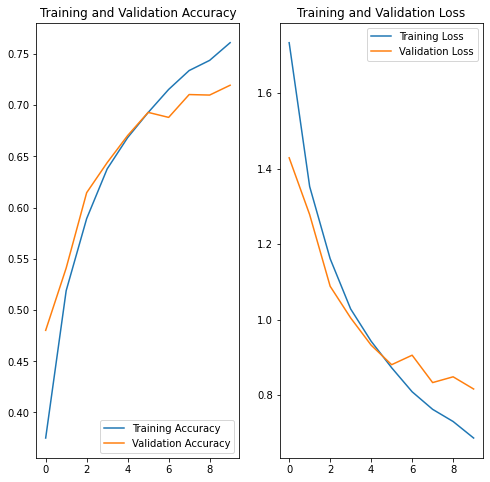

In [ ]:
show_accuracy(result5)

**#6 커널 오름차순 레이어 추가**

In [ ]:
model6 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result6 = model6.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model6.summary()

Epoch 1/10
98/98 [==============================] - 3s 29ms/step - loss: 1.7030 - accuracy: 0.3821 - val_loss: 1.4164 - val_accuracy: 0.4907
Epoch 2/10
98/98 [==============================] - 3s 27ms/step - loss: 1.2763 - accuracy: 0.5400 - val_loss: 1.1840 - val_accuracy: 0.5800
Epoch 3/10
98/98 [==============================] - 3s 28ms/step - loss: 1.0865 - accuracy: 0.6161 - val_loss: 1.0611 - val_accuracy: 0.6252
Epoch 4/10
98/98 [==============================] - 3s 29ms/step - loss: 0.9792 - accuracy: 0.6537 - val_loss: 0.9976 - val_accuracy: 0.6492
Epoch 5/10
98/98 [==============================] - 3s 29ms/step - loss: 0.8590 - accuracy: 0.6967 - val_loss: 0.9307 - val_accuracy: 0.6727
Epoch 6/10
98/98 [==============================] - 3s 29ms/step - loss: 0.7866 - accuracy: 0.7233 - val_loss: 0.8653 - val_accuracy: 0.6982
Epoch 7/10
98/98 [==============================] - 3s 29ms/step - loss: 0.7189 - accuracy: 0.7487 - val_loss: 0.8532 - val_accuracy: 0.7026
Epoch 8/10
98

In [ ]:
test_loss, test_acc = model6.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.8038 - accuracy: 0.7354
0.8037531971931458
0.7354000210762024


(None, None)

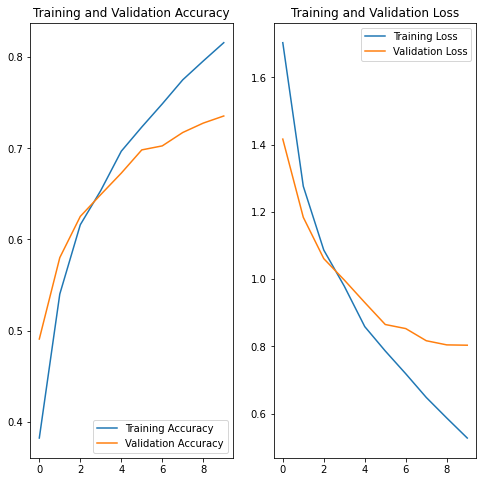

In [ ]:
show_accuracy(result6)

**#7-1 레이어 더 추가 오름차순**

In [ ]:
model7_1 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model7_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result7_1 = model7_1.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model7_1.summary()

Epoch 1/10
98/98 [==============================] - 5s 42ms/step - loss: 1.8060 - accuracy: 0.3373 - val_loss: 1.4953 - val_accuracy: 0.4434
Epoch 2/10
98/98 [==============================] - 4s 38ms/step - loss: 1.3708 - accuracy: 0.5034 - val_loss: 1.2646 - val_accuracy: 0.5444
Epoch 3/10
98/98 [==============================] - 4s 38ms/step - loss: 1.1616 - accuracy: 0.5852 - val_loss: 1.1110 - val_accuracy: 0.6052
Epoch 4/10
98/98 [==============================] - 4s 39ms/step - loss: 1.0312 - accuracy: 0.6353 - val_loss: 1.0571 - val_accuracy: 0.6310
Epoch 5/10
98/98 [==============================] - 4s 39ms/step - loss: 0.9187 - accuracy: 0.6755 - val_loss: 0.9731 - val_accuracy: 0.6578
Epoch 6/10
98/98 [==============================] - 4s 40ms/step - loss: 0.8267 - accuracy: 0.7084 - val_loss: 0.9079 - val_accuracy: 0.6768
Epoch 7/10
98/98 [==============================] - 4s 40ms/step - loss: 0.7471 - accuracy: 0.7380 - val_loss: 0.8691 - val_accuracy: 0.6982
Epoch 8/10
98

In [ ]:
test_loss, test_acc = model7_1.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.8730 - accuracy: 0.7093
0.8730310797691345
0.7092999815940857


(None, None)

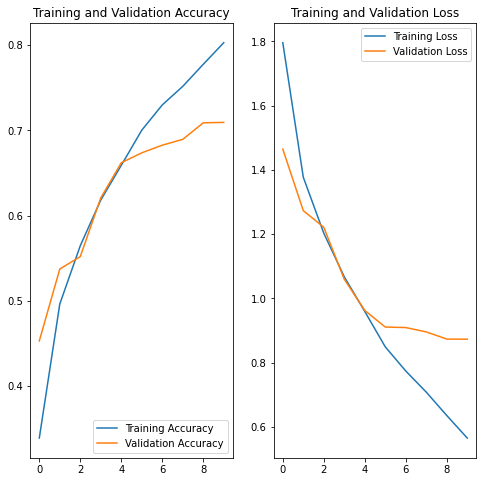

In [ ]:
show_accuracy(result7_1)

**#7-2 레이어 추가 내림차순**

In [ ]:
model7_2 = keras.Sequential([
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model7_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result7_2 = model7_2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model7_2.summary()

Epoch 1/10
98/98 [==============================] - 9s 87ms/step - loss: 1.8238 - accuracy: 0.3365 - val_loss: 1.5824 - val_accuracy: 0.4232
Epoch 2/10
98/98 [==============================] - 8s 85ms/step - loss: 1.4121 - accuracy: 0.4912 - val_loss: 1.3230 - val_accuracy: 0.5181
Epoch 3/10
98/98 [==============================] - 8s 85ms/step - loss: 1.2408 - accuracy: 0.5558 - val_loss: 1.1606 - val_accuracy: 0.5864
Epoch 4/10
98/98 [==============================] - 8s 85ms/step - loss: 1.1094 - accuracy: 0.6040 - val_loss: 1.0585 - val_accuracy: 0.6173
Epoch 5/10
98/98 [==============================] - 8s 85ms/step - loss: 1.0272 - accuracy: 0.6342 - val_loss: 0.9897 - val_accuracy: 0.6498
Epoch 6/10
98/98 [==============================] - 8s 85ms/step - loss: 0.9223 - accuracy: 0.6727 - val_loss: 0.9547 - val_accuracy: 0.6560
Epoch 7/10
98/98 [==============================] - 8s 84ms/step - loss: 0.8590 - accuracy: 0.6958 - val_loss: 0.9360 - val_accuracy: 0.6702
Epoch 8/10
98

**#8 epoch 20**

In [ ]:
epochs = 20

In [ ]:
model8 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result8 = model8.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model8.summary()

Epoch 1/10
98/98 [==============================] - 38s 91ms/step - loss: 1.7602 - accuracy: 0.3584 - val_loss: 1.4459 - val_accuracy: 0.4712
Epoch 2/10
98/98 [==============================] - 8s 82ms/step - loss: 1.3592 - accuracy: 0.5070 - val_loss: 1.2843 - val_accuracy: 0.5343
Epoch 3/10
98/98 [==============================] - 8s 82ms/step - loss: 1.1681 - accuracy: 0.5828 - val_loss: 1.1209 - val_accuracy: 0.6024
Epoch 4/10
98/98 [==============================] - 8s 82ms/step - loss: 1.0343 - accuracy: 0.6337 - val_loss: 1.0413 - val_accuracy: 0.6292
Epoch 5/10
98/98 [==============================] - 8s 82ms/step - loss: 0.9284 - accuracy: 0.6725 - val_loss: 1.0364 - val_accuracy: 0.6354
Epoch 6/10
98/98 [==============================] - 8s 82ms/step - loss: 0.8415 - accuracy: 0.7043 - val_loss: 0.9473 - val_accuracy: 0.6657
Epoch 7/10
98/98 [==============================] - 8s 82ms/step - loss: 0.7553 - accuracy: 0.7366 - val_loss: 0.8914 - val_accuracy: 0.6870
Epoch 8/10
9

In [ ]:
test_loss, test_acc = model8.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 2s - loss: 0.9225 - accuracy: 0.6967
0.9225171804428101
0.6966999769210815


(None, None)

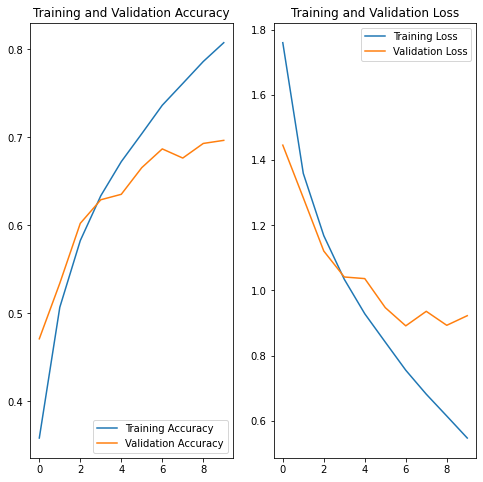

In [ ]:
show_accuracy(result8)

**#8_2 epoch 20에 레이어 2개씩일 때**

In [ ]:
epochs = 20
model8_2 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model8_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result8_2 = model8_2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model8_2.summary()

Epoch 1/20
98/98 [==============================] - 6s 58ms/step - loss: 1.6922 - accuracy: 0.3878 - val_loss: 1.3916 - val_accuracy: 0.4950
Epoch 2/20
98/98 [==============================] - 5s 54ms/step - loss: 1.2391 - accuracy: 0.5568 - val_loss: 1.1912 - val_accuracy: 0.5724
Epoch 3/20
98/98 [==============================] - 5s 54ms/step - loss: 1.0553 - accuracy: 0.6262 - val_loss: 1.0232 - val_accuracy: 0.6371
Epoch 4/20
98/98 [==============================] - 5s 54ms/step - loss: 0.9284 - accuracy: 0.6742 - val_loss: 0.9762 - val_accuracy: 0.6573
Epoch 5/20
98/98 [==============================] - 5s 54ms/step - loss: 0.8407 - accuracy: 0.7047 - val_loss: 0.8697 - val_accuracy: 0.6899
Epoch 6/20
98/98 [==============================] - 5s 53ms/step - loss: 0.7599 - accuracy: 0.7343 - val_loss: 0.8589 - val_accuracy: 0.7039
Epoch 7/20
98/98 [==============================] - 5s 54ms/step - loss: 0.6827 - accuracy: 0.7599 - val_loss: 0.8317 - val_accuracy: 0.7110
Epoch 8/20
98

In [ ]:
test_loss, test_acc = model8_2.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.7945 - accuracy: 0.7290
0.7944596409797668
0.7289999723434448


(None, None)

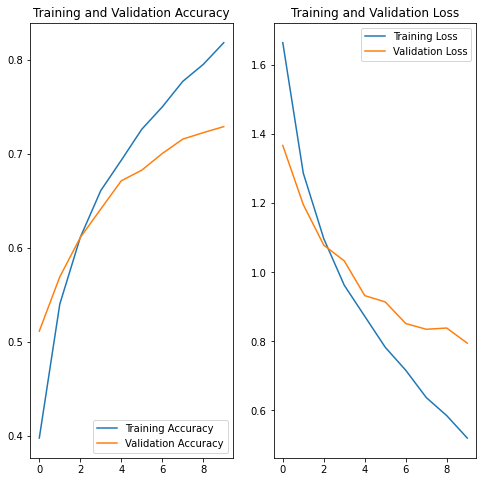

In [ ]:
show_accuracy(result8_2)

**#8-3 epoch 100 layer 2개씩**

In [ ]:
epochs=100
model8_3 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model8_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result8_3 = model8_3.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model8_3.summary()

Epoch 1/100
98/98 [==============================] - 6s 58ms/step - loss: 1.7189 - accuracy: 0.3797 - val_loss: 1.4017 - val_accuracy: 0.4918
Epoch 2/100
98/98 [==============================] - 5s 53ms/step - loss: 1.3152 - accuracy: 0.5295 - val_loss: 1.2154 - val_accuracy: 0.5719
Epoch 3/100
98/98 [==============================] - 5s 52ms/step - loss: 1.1450 - accuracy: 0.5938 - val_loss: 1.1210 - val_accuracy: 0.6042
Epoch 4/100
98/98 [==============================] - 5s 53ms/step - loss: 1.0110 - accuracy: 0.6438 - val_loss: 1.0275 - val_accuracy: 0.6360
Epoch 5/100
98/98 [==============================] - 5s 53ms/step - loss: 0.9185 - accuracy: 0.6758 - val_loss: 0.9427 - val_accuracy: 0.6657
Epoch 6/100
98/98 [==============================] - 5s 53ms/step - loss: 0.8296 - accuracy: 0.7063 - val_loss: 0.9056 - val_accuracy: 0.6823
Epoch 7/100
98/98 [==============================] - 5s 54ms/step - loss: 0.7525 - accuracy: 0.7360 - val_loss: 0.8631 - val_accuracy: 0.7006
Epoch 

**#9 drop out 0.5**

In [ ]:
epochs=20
dropout = 0.5
model9 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result9 = model9.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model9.summary()

Epoch 1/20
98/98 [==============================] - 10s 89ms/step - loss: 1.8222 - accuracy: 0.3375 - val_loss: 1.4604 - val_accuracy: 0.4681
Epoch 2/20
98/98 [==============================] - 8s 82ms/step - loss: 1.3971 - accuracy: 0.4937 - val_loss: 1.2206 - val_accuracy: 0.5577
Epoch 3/20
98/98 [==============================] - 8s 82ms/step - loss: 1.2130 - accuracy: 0.5639 - val_loss: 1.0898 - val_accuracy: 0.6079
Epoch 4/20
98/98 [==============================] - 8s 82ms/step - loss: 1.0787 - accuracy: 0.6146 - val_loss: 0.9827 - val_accuracy: 0.6528
Epoch 5/20
98/98 [==============================] - 8s 82ms/step - loss: 1.0062 - accuracy: 0.6407 - val_loss: 0.9653 - val_accuracy: 0.6546
Epoch 6/20
98/98 [==============================] - 8s 82ms/step - loss: 0.9265 - accuracy: 0.6692 - val_loss: 0.8764 - val_accuracy: 0.6917
Epoch 7/20
98/98 [==============================] - 8s 82ms/step - loss: 0.8765 - accuracy: 0.6890 - val_loss: 0.8430 - val_accuracy: 0.7002
Epoch 8/20
9

In [ ]:
test_loss, test_acc = model9.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

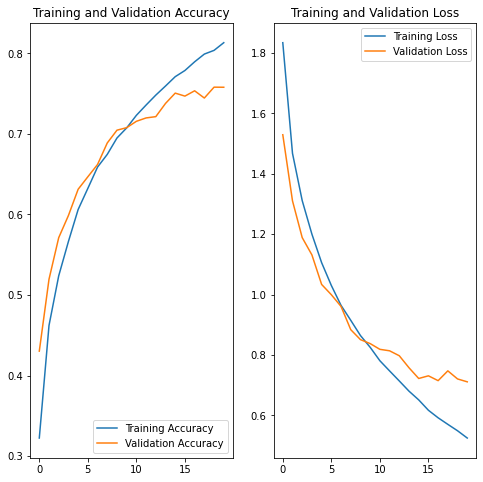

In [ ]:
show_accuracy(result9)

**#9-2 add drop out 레이어가 2개씩 일 때**

In [ ]:
dropout = 0.5
epochs=20
model9_2 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model9_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result9_2 = model9_2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model9_2.summary()

Epoch 1/20
98/98 [==============================] - 6s 59ms/step - loss: 1.7322 - accuracy: 0.3666 - val_loss: 1.4290 - val_accuracy: 0.4804
Epoch 2/20
98/98 [==============================] - 5s 54ms/step - loss: 1.3922 - accuracy: 0.4993 - val_loss: 1.2488 - val_accuracy: 0.5514
Epoch 3/20
98/98 [==============================] - 5s 53ms/step - loss: 1.2416 - accuracy: 0.5542 - val_loss: 1.1278 - val_accuracy: 0.6010
Epoch 4/20
98/98 [==============================] - 6s 57ms/step - loss: 1.1307 - accuracy: 0.5944 - val_loss: 1.0414 - val_accuracy: 0.6335
Epoch 5/20
98/98 [==============================] - 5s 54ms/step - loss: 1.0486 - accuracy: 0.6265 - val_loss: 0.9735 - val_accuracy: 0.6585
Epoch 6/20
98/98 [==============================] - 5s 54ms/step - loss: 0.9769 - accuracy: 0.6518 - val_loss: 0.9495 - val_accuracy: 0.6641
Epoch 7/20
98/98 [==============================] - 5s 53ms/step - loss: 0.9271 - accuracy: 0.6714 - val_loss: 0.8920 - val_accuracy: 0.6848
Epoch 8/20
98

In [ ]:
test_loss, test_acc = model9_2.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6874 - accuracy: 0.7608
0.6874169707298279
0.7608000040054321


(None, None)

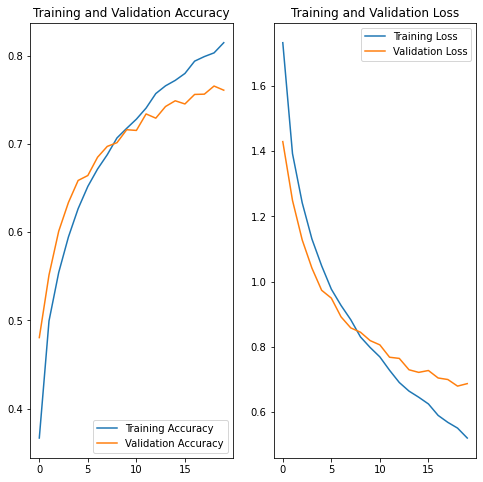

In [ ]:
show_accuracy(result9_2)

**#10 add drop out**

In [ ]:
 model10 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result10 = model10.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model10.summary()

Epoch 1/20
98/98 [==============================] - 4s 39ms/step - loss: 1.9279 - accuracy: 0.2846 - val_loss: 1.7280 - val_accuracy: 0.3581
Epoch 2/20
98/98 [==============================] - 4s 36ms/step - loss: 1.5570 - accuracy: 0.4198 - val_loss: 1.5107 - val_accuracy: 0.4487
Epoch 3/20
98/98 [==============================] - 4s 37ms/step - loss: 1.4147 - accuracy: 0.4809 - val_loss: 1.2963 - val_accuracy: 0.5279
Epoch 4/20
98/98 [==============================] - 4s 37ms/step - loss: 1.3192 - accuracy: 0.5201 - val_loss: 1.2452 - val_accuracy: 0.5452
Epoch 5/20
98/98 [==============================] - 4s 37ms/step - loss: 1.2375 - accuracy: 0.5502 - val_loss: 1.1938 - val_accuracy: 0.5736
Epoch 6/20
98/98 [==============================] - 4s 37ms/step - loss: 1.1696 - accuracy: 0.5769 - val_loss: 1.1613 - val_accuracy: 0.5914
Epoch 7/20
98/98 [==============================] - 4s 37ms/step - loss: 1.1196 - accuracy: 0.5973 - val_loss: 1.1089 - val_accuracy: 0.6118
Epoch 8/20
98

In [ ]:
 test_loss, test_acc = model10.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

NameError: ignored

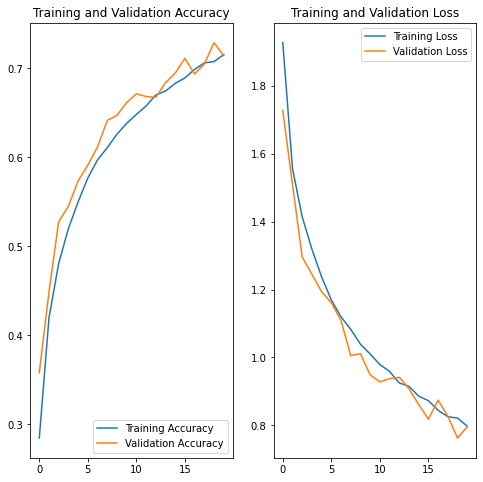

In [ ]:
show_accuracy(result10)

**#10-2 drop out 3개 레이어 2개씩**

In [ ]:
 
 
epochs = 20
dropout = 0.5
model10_2 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model10_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result10_2 = model10_2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model10_2.summary()

Epoch 1/20
98/98 [==============================] - 7s 61ms/step - loss: 1.9933 - accuracy: 0.2668 - val_loss: 1.7076 - val_accuracy: 0.3873
Epoch 2/20
98/98 [==============================] - 6s 57ms/step - loss: 1.5871 - accuracy: 0.4134 - val_loss: 1.4460 - val_accuracy: 0.4641
Epoch 3/20
98/98 [==============================] - 6s 57ms/step - loss: 1.4415 - accuracy: 0.4687 - val_loss: 1.3148 - val_accuracy: 0.5223
Epoch 4/20
98/98 [==============================] - 6s 58ms/step - loss: 1.3423 - accuracy: 0.5094 - val_loss: 1.2116 - val_accuracy: 0.5634
Epoch 5/20
98/98 [==============================] - 6s 57ms/step - loss: 1.2683 - accuracy: 0.5355 - val_loss: 1.1851 - val_accuracy: 0.5690
Epoch 6/20
98/98 [==============================] - 6s 58ms/step - loss: 1.2032 - accuracy: 0.5670 - val_loss: 1.0901 - val_accuracy: 0.6092
Epoch 7/20
98/98 [==============================] - 6s 58ms/step - loss: 1.1576 - accuracy: 0.5828 - val_loss: 1.0799 - val_accuracy: 0.6127
Epoch 8/20
98

In [ ]:
 test_loss, test_acc = model10_2.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.7584 - accuracy: 0.7301
0.758415162563324
0.7300999760627747


(None, None)

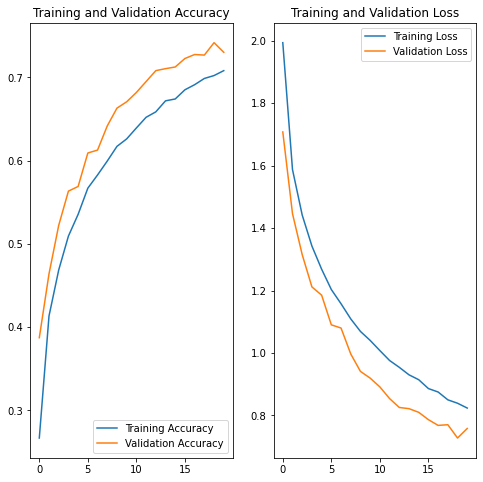

In [ ]:
show_accuracy(result10_2)

**#11 drop out 2개**

In [ ]:
 model11 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result11 = model11.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model11.summary()

Epoch 1/20
98/98 [==============================] - 5s 40ms/step - loss: 1.9405 - accuracy: 0.2808 - val_loss: 1.6620 - val_accuracy: 0.3894
Epoch 2/20
98/98 [==============================] - 4s 37ms/step - loss: 1.5486 - accuracy: 0.4262 - val_loss: 1.4232 - val_accuracy: 0.4750
Epoch 3/20
98/98 [==============================] - 4s 37ms/step - loss: 1.3637 - accuracy: 0.5013 - val_loss: 1.1965 - val_accuracy: 0.5600
Epoch 4/20
98/98 [==============================] - 4s 38ms/step - loss: 1.2382 - accuracy: 0.5485 - val_loss: 1.1528 - val_accuracy: 0.5805
Epoch 5/20
98/98 [==============================] - 4s 37ms/step - loss: 1.1518 - accuracy: 0.5822 - val_loss: 1.0882 - val_accuracy: 0.6132
Epoch 6/20
98/98 [==============================] - 4s 38ms/step - loss: 1.0876 - accuracy: 0.6080 - val_loss: 1.0161 - val_accuracy: 0.6340
Epoch 7/20
98/98 [==============================] - 4s 38ms/step - loss: 1.0327 - accuracy: 0.6300 - val_loss: 0.9838 - val_accuracy: 0.6544
Epoch 8/20
98

In [ ]:
 test_loss, test_acc = model11.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

In [ ]:
show_accurarcy(result11)

**#11-2 dropout 2개만 & 레이어 2개씩만**

In [ ]:
 dropout = 0.5
 epochs = 20
 model11_2 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model11_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result11_2 = model11_2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model11_2.summary()

Epoch 1/20
98/98 [==============================] - 7s 59ms/step - loss: 1.8630 - accuracy: 0.3019 - val_loss: 1.5244 - val_accuracy: 0.4479
Epoch 2/20
98/98 [==============================] - 5s 55ms/step - loss: 1.4661 - accuracy: 0.4646 - val_loss: 1.2761 - val_accuracy: 0.5383
Epoch 3/20
98/98 [==============================] - 5s 55ms/step - loss: 1.3132 - accuracy: 0.5204 - val_loss: 1.1772 - val_accuracy: 0.5771
Epoch 4/20
98/98 [==============================] - 5s 55ms/step - loss: 1.2052 - accuracy: 0.5643 - val_loss: 1.1217 - val_accuracy: 0.5925
Epoch 5/20
98/98 [==============================] - 5s 54ms/step - loss: 1.1423 - accuracy: 0.5878 - val_loss: 1.0221 - val_accuracy: 0.6342
Epoch 6/20
98/98 [==============================] - 5s 55ms/step - loss: 1.0715 - accuracy: 0.6129 - val_loss: 0.9601 - val_accuracy: 0.6540
Epoch 7/20
98/98 [==============================] - 5s 55ms/step - loss: 1.0184 - accuracy: 0.6354 - val_loss: 0.9127 - val_accuracy: 0.6751
Epoch 8/20
98

In [ ]:
test_loss, test_acc = model11_2.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6560 - accuracy: 0.7705
0.656004786491394
0.7705000042915344


(None, None)

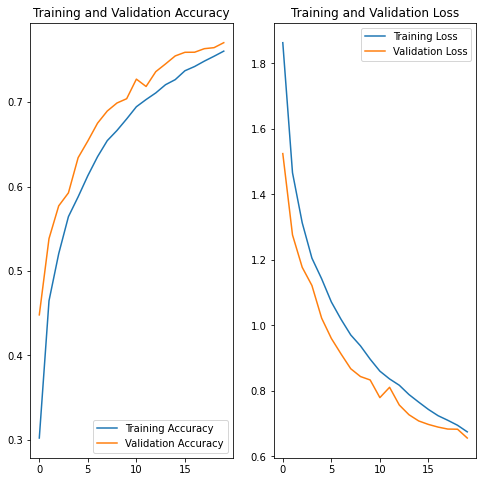

In [ ]:
show_accuracy(result11_2)

**#12 epochs 100**

In [ ]:
 dropout = 0.5
 epochs = 100
 
 model12 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result12 = model12.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model12.summary()

Epoch 1/100
98/98 [==============================] - 5s 42ms/step - loss: 1.8825 - accuracy: 0.3020 - val_loss: 1.5567 - val_accuracy: 0.4255
Epoch 2/100
98/98 [==============================] - 4s 37ms/step - loss: 1.5261 - accuracy: 0.4368 - val_loss: 1.3847 - val_accuracy: 0.4923
Epoch 3/100
98/98 [==============================] - 4s 37ms/step - loss: 1.3777 - accuracy: 0.4952 - val_loss: 1.3030 - val_accuracy: 0.5225
Epoch 4/100
98/98 [==============================] - 4s 37ms/step - loss: 1.2977 - accuracy: 0.5277 - val_loss: 1.1853 - val_accuracy: 0.5714
Epoch 5/100
98/98 [==============================] - 4s 37ms/step - loss: 1.2063 - accuracy: 0.5617 - val_loss: 1.1282 - val_accuracy: 0.5910
Epoch 6/100
98/98 [==============================] - 4s 37ms/step - loss: 1.1586 - accuracy: 0.5783 - val_loss: 1.0613 - val_accuracy: 0.6241
Epoch 7/100
98/98 [==============================] - 4s 37ms/step - loss: 1.0909 - accuracy: 0.6070 - val_loss: 1.0091 - val_accuracy: 0.6395
Epoch 

In [ ]:
test_loss, test_acc = model12.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6131 - accuracy: 0.7982
0.6131131052970886
0.7982000112533569


(None, None)

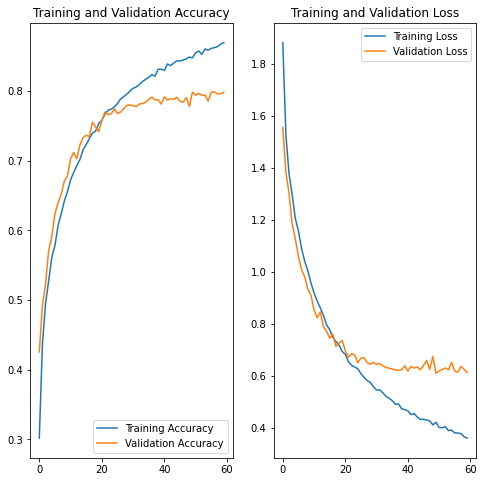

In [ ]:
show_accuracy(result12)

**#12-2 epoch 100 & 레이어 2개씩 & dropout 2개**

In [ ]:
 dropout = 0.5
 epochs = 100
 
 model12_2 = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
 
model12_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result12_2 = model12_2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model12_2.summary()

Epoch 1/100
98/98 [==============================] - 7s 60ms/step - loss: 1.8408 - accuracy: 0.3226 - val_loss: 1.4857 - val_accuracy: 0.4620
Epoch 2/100
98/98 [==============================] - 5s 55ms/step - loss: 1.4728 - accuracy: 0.4572 - val_loss: 1.3145 - val_accuracy: 0.5164
Epoch 3/100
98/98 [==============================] - 5s 54ms/step - loss: 1.3069 - accuracy: 0.5224 - val_loss: 1.1811 - val_accuracy: 0.5759
Epoch 4/100
98/98 [==============================] - 5s 55ms/step - loss: 1.2231 - accuracy: 0.5579 - val_loss: 1.0861 - val_accuracy: 0.6145
Epoch 5/100
98/98 [==============================] - 5s 55ms/step - loss: 1.1380 - accuracy: 0.5919 - val_loss: 1.0085 - val_accuracy: 0.6418
Epoch 6/100
98/98 [==============================] - 5s 55ms/step - loss: 1.0726 - accuracy: 0.6128 - val_loss: 0.9607 - val_accuracy: 0.6591
Epoch 7/100
98/98 [==============================] - 5s 54ms/step - loss: 1.0228 - accuracy: 0.6340 - val_loss: 0.9039 - val_accuracy: 0.6751
Epoch 

In [ ]:
test_loss, test_acc = model12_2.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.5936 - accuracy: 0.8048
0.5935570597648621
0.8047999739646912


(None, None)

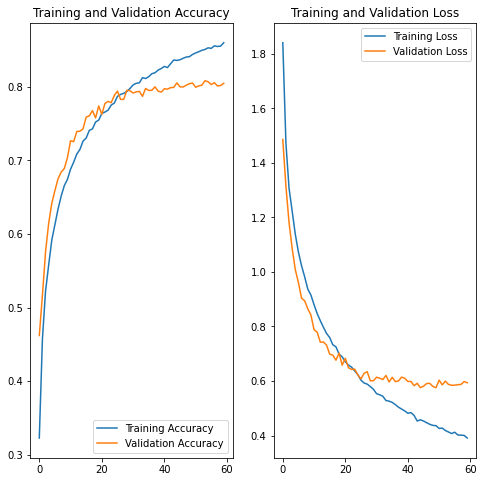

In [ ]:
show_accuracy(result12_2)

**#13 dropout 3개 & epochs 100**

In [ ]:
 dropout = 0.5
 epochs = 100
 
 model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result13 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model.summary()

Epoch 1/100
98/98 [==============================] - 36s 45ms/step - loss: 1.8904 - accuracy: 0.2915 - val_loss: 1.6804 - val_accuracy: 0.3787
Epoch 2/100
98/98 [==============================] - 4s 37ms/step - loss: 1.5729 - accuracy: 0.4123 - val_loss: 1.4365 - val_accuracy: 0.4721
Epoch 3/100
98/98 [==============================] - 4s 37ms/step - loss: 1.4382 - accuracy: 0.4638 - val_loss: 1.5610 - val_accuracy: 0.4427
Epoch 4/100
98/98 [==============================] - 4s 37ms/step - loss: 1.3529 - accuracy: 0.5025 - val_loss: 1.2871 - val_accuracy: 0.5403
Epoch 5/100
98/98 [==============================] - 4s 37ms/step - loss: 1.2812 - accuracy: 0.5323 - val_loss: 1.2232 - val_accuracy: 0.5565
Epoch 6/100
98/98 [==============================] - 4s 38ms/step - loss: 1.2096 - accuracy: 0.5609 - val_loss: 1.1245 - val_accuracy: 0.5986
Epoch 7/100
98/98 [==============================] - 4s 38ms/step - loss: 1.1607 - accuracy: 0.5810 - val_loss: 1.2220 - val_accuracy: 0.5669
Epoch

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6493 - accuracy: 0.7837
0.6493158936500549
0.7836999893188477


(None, None)

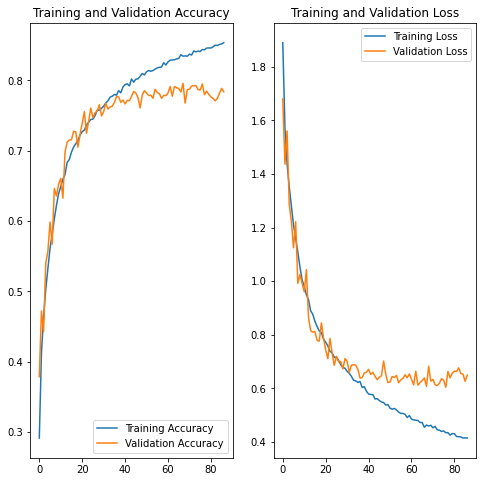

In [ ]:
show_accuracy(result13)

**#14 add 128 kernel layers**

In [ ]:
dropout = 0.5
epochs = 100

model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result14 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model.summary()

Epoch 1/100
98/98 [==============================] - 6s 48ms/step - loss: 2.0527 - accuracy: 0.2122 - val_loss: 1.8274 - val_accuracy: 0.2804
Epoch 2/100
98/98 [==============================] - 4s 42ms/step - loss: 1.6458 - accuracy: 0.3679 - val_loss: 1.4875 - val_accuracy: 0.4457
Epoch 3/100
98/98 [==============================] - 4s 41ms/step - loss: 1.4562 - accuracy: 0.4583 - val_loss: 1.3487 - val_accuracy: 0.5061
Epoch 4/100
98/98 [==============================] - 4s 41ms/step - loss: 1.3472 - accuracy: 0.5077 - val_loss: 1.2443 - val_accuracy: 0.5427
Epoch 5/100
98/98 [==============================] - 4s 41ms/step - loss: 1.2698 - accuracy: 0.5360 - val_loss: 1.1634 - val_accuracy: 0.5774
Epoch 6/100
98/98 [==============================] - 4s 41ms/step - loss: 1.2133 - accuracy: 0.5604 - val_loss: 1.1698 - val_accuracy: 0.5827
Epoch 7/100
98/98 [==============================] - 4s 41ms/step - loss: 1.1455 - accuracy: 0.5884 - val_loss: 1.0922 - val_accuracy: 0.6045
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6401 - accuracy: 0.7884
0.6401111483573914
0.7883999943733215


(None, None)

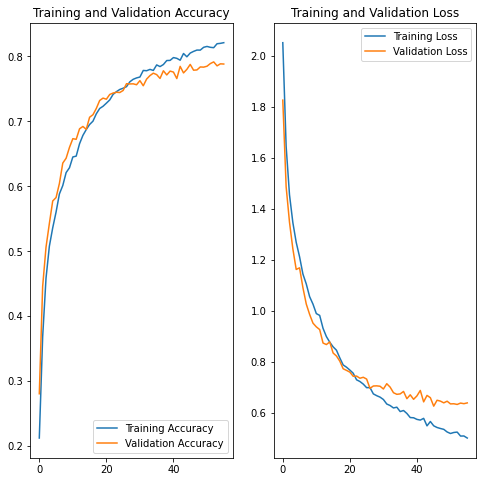

In [ ]:
show_accuracy(result14)

**#15 reduce layer and increase kernel**

In [ ]:
dropout = 0.5
epochs = 100

model15 = keras.Sequential([
    
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model15.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result15 = model15.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model15.summary()

Epoch 1/100
98/98 [==============================] - 40s 67ms/step - loss: 2.0112 - accuracy: 0.3816 - val_loss: 1.5159 - val_accuracy: 0.5369
Epoch 2/100
98/98 [==============================] - 5s 48ms/step - loss: 1.4577 - accuracy: 0.5591 - val_loss: 1.2844 - val_accuracy: 0.6339
Epoch 3/100
98/98 [==============================] - 5s 48ms/step - loss: 1.2551 - accuracy: 0.6415 - val_loss: 1.1274 - val_accuracy: 0.6915
Epoch 4/100
98/98 [==============================] - 5s 48ms/step - loss: 1.1450 - accuracy: 0.6829 - val_loss: 1.0765 - val_accuracy: 0.7118
Epoch 5/100
98/98 [==============================] - 5s 48ms/step - loss: 1.0790 - accuracy: 0.7123 - val_loss: 1.0185 - val_accuracy: 0.7369
Epoch 6/100
98/98 [==============================] - 5s 49ms/step - loss: 1.0232 - accuracy: 0.7350 - val_loss: 0.9585 - val_accuracy: 0.7644
Epoch 7/100
98/98 [==============================] - 5s 49ms/step - loss: 0.9795 - accuracy: 0.7544 - val_loss: 0.9370 - val_accuracy: 0.7761
Epoch

In [ ]:
test_loss, test_acc = model15.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.8209 - accuracy: 0.8305
0.820885956287384
0.8305000066757202


(None, None)

**#15-2 15번에 레이어 2개씩**

In [ ]:
dropout = 0.5
epochs = 100

model15_2 = keras.Sequential([
    
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model15_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result15_2 = model15_2.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model15_2.summary()

Epoch 1/100
98/98 [==============================] - 24s 178ms/step - loss: 2.4319 - accuracy: 0.1881 - val_loss: 1.9096 - val_accuracy: 0.2786
Epoch 2/100
98/98 [==============================] - 12s 121ms/step - loss: 1.7767 - accuracy: 0.3443 - val_loss: 1.6573 - val_accuracy: 0.3951
Epoch 3/100
98/98 [==============================] - 12s 121ms/step - loss: 1.5664 - accuracy: 0.4387 - val_loss: 1.4551 - val_accuracy: 0.4852
Epoch 4/100
98/98 [==============================] - 12s 120ms/step - loss: 1.4188 - accuracy: 0.5103 - val_loss: 1.3433 - val_accuracy: 0.5457
Epoch 5/100
98/98 [==============================] - 12s 119ms/step - loss: 1.3024 - accuracy: 0.5641 - val_loss: 1.1807 - val_accuracy: 0.6111
Epoch 6/100
98/98 [==============================] - 12s 118ms/step - loss: 1.1984 - accuracy: 0.6080 - val_loss: 1.1105 - val_accuracy: 0.6413
Epoch 7/100
98/98 [==============================] - 12s 119ms/step - loss: 1.1197 - accuracy: 0.6379 - val_loss: 1.0600 - val_accuracy:

**#15번에 dropout 1개만**

In [ ]:
dropout = 0.5
epochs = 100

model15_3 = keras.Sequential([
    
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model15_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result15_3 = model15_3.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model15_3.summary()

Epoch 1/100
98/98 [==============================] - 14s 112ms/step - loss: 2.0626 - accuracy: 0.3553 - val_loss: 1.5649 - val_accuracy: 0.5072
Epoch 2/100
98/98 [==============================] - 9s 90ms/step - loss: 1.4810 - accuracy: 0.5331 - val_loss: 1.2623 - val_accuracy: 0.6189
Epoch 3/100
98/98 [==============================] - 9s 90ms/step - loss: 1.2701 - accuracy: 0.6210 - val_loss: 1.1306 - val_accuracy: 0.6758
Epoch 4/100
98/98 [==============================] - 9s 90ms/step - loss: 1.1462 - accuracy: 0.6724 - val_loss: 1.0533 - val_accuracy: 0.7067
Epoch 5/100
98/98 [==============================] - 9s 91ms/step - loss: 1.0854 - accuracy: 0.6978 - val_loss: 1.0428 - val_accuracy: 0.7262
Epoch 6/100
98/98 [==============================] - 9s 91ms/step - loss: 1.0260 - accuracy: 0.7238 - val_loss: 0.9784 - val_accuracy: 0.7475
Epoch 7/100
98/98 [==============================] - 9s 91ms/step - loss: 0.9942 - accuracy: 0.7363 - val_loss: 0.9647 - val_accuracy: 0.7501
Epoc

In [ ]:
test_loss, test_acc = model15_3.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

NameError: ignored

In [ ]:
show_accuracy(model15_3)

TypeError: ignored

**#16 increase kernel**

In [ ]:
dropout = 0.5
epochs = 100

model16 = keras.Sequential([
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result16 = model16.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model16.summary()

Epoch 1/100
98/98 [==============================] - 12s 119ms/step - loss: 2.4453 - accuracy: 0.2998 - val_loss: 1.7641 - val_accuracy: 0.4440
Epoch 2/100
98/98 [==============================] - 12s 117ms/step - loss: 1.5943 - accuracy: 0.4979 - val_loss: 1.3461 - val_accuracy: 0.5908
Epoch 3/100
98/98 [==============================] - 12s 118ms/step - loss: 1.3147 - accuracy: 0.5909 - val_loss: 1.1921 - val_accuracy: 0.6364
Epoch 4/100
98/98 [==============================] - 12s 118ms/step - loss: 1.1807 - accuracy: 0.6398 - val_loss: 1.0797 - val_accuracy: 0.6898
Epoch 5/100
98/98 [==============================] - 12s 118ms/step - loss: 1.0890 - accuracy: 0.6761 - val_loss: 0.9862 - val_accuracy: 0.7269
Epoch 6/100
98/98 [==============================] - 11s 117ms/step - loss: 1.0288 - accuracy: 0.7035 - val_loss: 0.9713 - val_accuracy: 0.7279
Epoch 7/100
98/98 [==============================] - 11s 117ms/step - loss: 0.9951 - accuracy: 0.7166 - val_loss: 0.9507 - val_accuracy:

In [ ]:
test_loss, test_acc = model16.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 2s - loss: 0.8271 - accuracy: 0.8245
0.827145516872406
0.8245000243186951


(None, None)

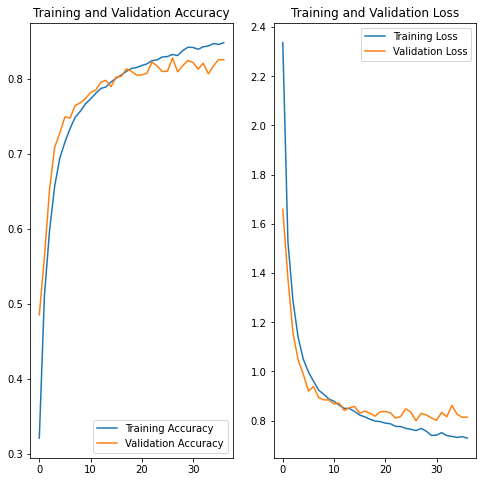

In [ ]:
show_accuracy(result16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


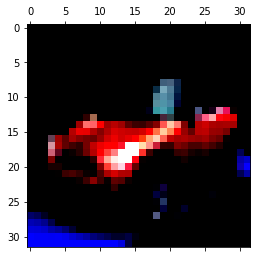

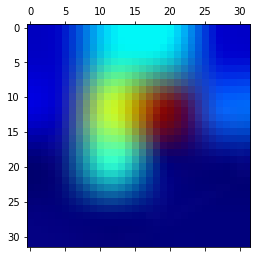

In [ ]:
last_conv_layer_name = 'conv2d_3'
index = 6555
img = x_test[index]
plt.matshow(img)
img = img.reshape(-1, 32, 32, 3)
src_img = img.reshape(32, 32, 3)
heatmap = make_gradcam_heatmap(img, model16, last_conv_layer_name)
CAM = save_and_display_gradcam(src_img, heatmap, alpha=0.4)
plt.matshow(CAM)
print('label : ', y_test[index])

**t-sne (2번째 인자 레이어로 바꿔주면 다른 레이어 볼 수 있음)**

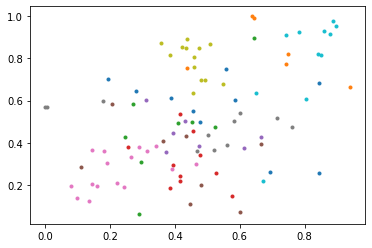

In [ ]:
get_tsne(model16, 'conv2d_3', x_test, y_test, 4, 4, 1024, size=300)

**#17 increase kernel**

In [ ]:
dropout = 0.5
epochs = 100

model17 = keras.Sequential([
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Conv2D(2048, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model17.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result17 = model17.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model17.summary()

Epoch 1/100
98/98 [==============================] - 68s 282ms/step - loss: 3.1114 - accuracy: 0.1533 - val_loss: 2.3021 - val_accuracy: 0.2297
Epoch 2/100
98/98 [==============================] - 18s 189ms/step - loss: 2.0268 - accuracy: 0.2977 - val_loss: 1.7288 - val_accuracy: 0.3936
Epoch 3/100
98/98 [==============================] - 19s 191ms/step - loss: 1.6531 - accuracy: 0.4283 - val_loss: 1.4999 - val_accuracy: 0.4905
Epoch 4/100
98/98 [==============================] - 19s 192ms/step - loss: 1.4506 - accuracy: 0.5095 - val_loss: 1.2966 - val_accuracy: 0.5738
Epoch 5/100
98/98 [==============================] - 19s 193ms/step - loss: 1.3381 - accuracy: 0.5551 - val_loss: 1.2127 - val_accuracy: 0.6037
Epoch 6/100
98/98 [==============================] - 19s 193ms/step - loss: 1.2489 - accuracy: 0.5925 - val_loss: 1.1346 - val_accuracy: 0.6452
Epoch 7/100
98/98 [==============================] - 19s 195ms/step - loss: 1.2008 - accuracy: 0.6123 - val_loss: 1.1014 - val_accuracy:

In [ ]:
test_loss, test_acc = model17.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 4s - loss: 0.7656 - accuracy: 0.8086
0.7655773162841797
0.8086000084877014


(None, None)

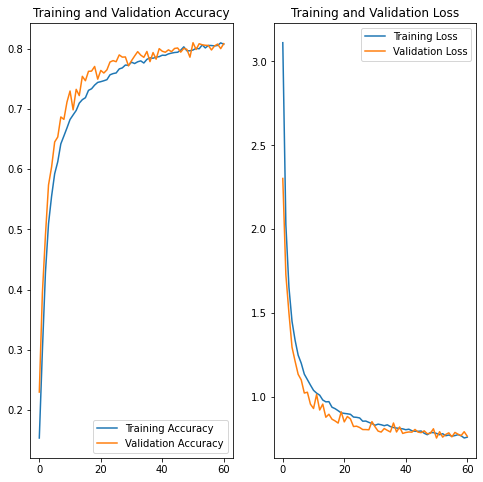

In [ ]:
show_accuracy(result17)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


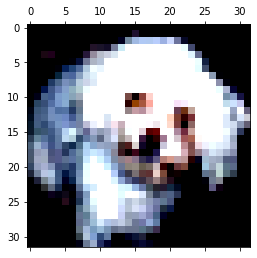

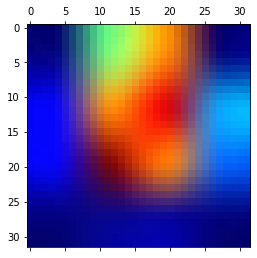

In [ ]:
last_conv_layer_name = 'conv2d_8'

img = x_test[1000]
plt.matshow(img)
img = img.reshape(-1, 32, 32, 3)
src_img = img.reshape(32, 32, 3)
heatmap = make_gradcam_heatmap(img, model17, last_conv_layer_name)
CAM = save_and_display_gradcam(src_img, heatmap, alpha=0.4)
plt.matshow(CAM)

**# 18 16번 모델에 GAP(Global Average Pooling) 추가**

In [ ]:
dropout = 0.5
epochs = 100

model18 = keras.Sequential([
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result18 = model18.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model18.summary()

Epoch 1/100
98/98 [==============================] - 12s 111ms/step - loss: 2.2796 - accuracy: 0.3356 - val_loss: 1.7165 - val_accuracy: 0.4603
Epoch 2/100
98/98 [==============================] - 11s 109ms/step - loss: 1.6086 - accuracy: 0.4844 - val_loss: 1.4341 - val_accuracy: 0.5434
Epoch 3/100
98/98 [==============================] - 11s 110ms/step - loss: 1.3883 - accuracy: 0.5634 - val_loss: 1.2826 - val_accuracy: 0.6014
Epoch 4/100
98/98 [==============================] - 11s 110ms/step - loss: 1.2800 - accuracy: 0.6107 - val_loss: 1.2094 - val_accuracy: 0.6345
Epoch 5/100
98/98 [==============================] - 11s 110ms/step - loss: 1.1935 - accuracy: 0.6449 - val_loss: 1.1150 - val_accuracy: 0.6740
Epoch 6/100
98/98 [==============================] - 11s 111ms/step - loss: 1.1474 - accuracy: 0.6632 - val_loss: 1.0906 - val_accuracy: 0.6866
Epoch 7/100
98/98 [==============================] - 11s 111ms/step - loss: 1.1074 - accuracy: 0.6852 - val_loss: 1.0448 - val_accuracy:

In [ ]:
test_loss, test_acc = model18.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 2s - loss: 0.8125 - accuracy: 0.8244
0.812518835067749
0.824400007724762


(None, None)

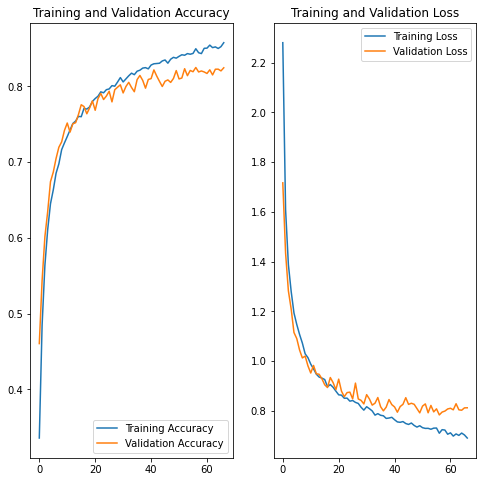

In [ ]:
show_accuracy(result18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 256)        

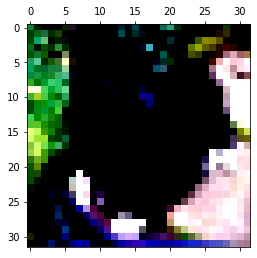

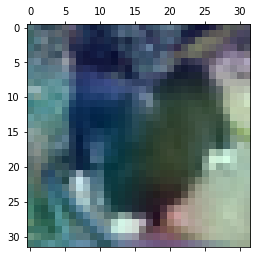

In [ ]:
model = model15
model.summary()
img = x_train[81]
plt.matshow(img)
img = img.reshape(-1, 32, 32, 3)
src_img = img.reshape(32, 32, 3)
last_conv_layer_name = 'conv2d_11'
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
b = save_and_display_gradcam(src_img, heatmap, alpha=0.004)
plt.matshow(b)
plt.show()